# 0. Abstract and Outline

The purpose of this document is to discuss the classification problem from a little bit abstract and general perspective. Particular emphasis will be given to the idea of generalization, i.e., the performance of the model on the underlying distribution that generates the data. We will also introduce the k-nearest neighbors model, which is an intuitive, powerful (in terms of prediction accuracy), but not so fast/scalable approach to address a generic prediction problem with discrete outcome variables. The kNN model will also be applied to address the long-term user retention prediction problem at Kwai. This document will present modeling details, case study, and Python code. 

Below is the outline of this document:

- In [Section 1](#section_1), we introduce a general framework for classification models evaluated under the "true" underlying data generating process. We also discuss the key challenge of predictive modeling that the underlying population distribution is unknown.

- In [Section 2](#section_2), we present the $k-$NN and discuss how it can be fitted. Applying $k-$NN to the case of predicting long-term user retention with short-term consumption features is also discussed.

- In [Section 3](#section_3), we provide several remarks on the $k-$NN model, including its model complexity, accuracy, speed, and the $k-$NN regression model.

<a id='section_1'></a>
# 1. A General Framework for Classification

We have witnessed an inherent tension when working with models. Any model is a simplified abstraction of reality and is "always wrong". The linear and generalized linear models such as linear regression and logistic regression explicitly make very strong assumptions for the probablistic process that actually generates the data (we call this process the data generating process). Both models assume certain functional forms of the relationship between outcome $Y$ and feature $X$, as well as the distributions of the random noises associated with the data. One may wonder, if the strong assumptions are invalidated (which is likely to be the case in practice), how we could make accurate predictions in this case. 

Therefore, we would like to first develop a general framework for classification problems. Examples include predicting
  
- Whether a user will watch a movie on Netflix;
- Whether a user will click an advertisement on Kwai;
- Whether a patient has lung cancer;
- Whether an email is spam;
- Whether a program should admit a new student;
- Many others where the outcome is discrete.


For expositional simplicity, we assume $Y\in\{0,1\}$ in this document, i.e., we consider a binary classification. As discussed earlier, the modeling effort should seek to achieve the goal that the prediction error can be controlled as small as possible under the underlying distribution or data generating process of the circumstances where your classifier will be used. For example, if Netflix builds a classification model to predict whether a user will watch a movie, the goal should be that the model can accurately predict whether a randomly sampled user will like a randomly chosen movie on the platform. As a supervised learning paradigm, a classification is trained by examples. Therefore, we assume the training data set $\mathcal D:=\{Y_i\in\{0,1\},X_{ij}:1\le i\le n,1\le j \le p\}$ is generated from **the same data generating process as the entire population** of interest. We are now ready to formulate the classification problem in the following abstract framework. 

----

<span style="font-family:Comic Sans MS">
    <p style="color:red">
Given a training data set $\mathcal D:=\{Y_i\in\{0,1\},X_{ij}:1\le i\le n,1\le j \le p\}$, we seek to find a classifier $\hat f(\cdot)$ (also known as a model) which maps from a feature $X$ to the outcomes $\{0,1\}$ so that the prediction error under the distribution that generates $\mathcal D$ (equivalently the entire population) is minimized.
        </p>
</span>    

----

For this document, we confine ourselves to the 0-1 loss as the metric to model performance. Specifically, we are interested in minimizing 

$$\mbox{0-1 Loss}=\mathbb P[\hat f(X)\ne Y]$$

where the probability is calculated under the "true" data generating process under which the data $(X,Y)$ is generated. The 0-1 feature simply measures the probability that the classifier will make a wrong prediction, which should be a natural choice of error function under the true distribution that generates the data. One should also note that other commonly used performance measures, such as overall accuracy, false-negative rate, false-positive rate, recall (sensitivity), specificity, precision, receiver operator characteristics (ROC) curve, and area under the curve (AUC) can all be evaluated under the true data generating process. Specifically, we have: 

- Overall Accuracy = $\mathbb P[\hat f(X)= Y]$, i.e., the probability that the model makes a correct prediction;
- False-positive rate = $\mathbb P[\hat f(X) \ne Y|Y=0]$, i.e., conditioned on that the actual outcome is negative, the probability that the model makes a wrong prediction;
- False-negative rate = $\mathbb P[\hat f(X) \ne Y|Y=1]$, i.e., conditioned on that the actual outcome is positive, the probability that the model makes a wrong prediction;
- Recall (sensitivity) = $\mathbb P[\hat f(X) = Y|Y=1]$, i.e., conditioned on that the actual outcome is positive, the probability that the model makes a correct prediction;
- Specificity = $\mathbb P[\hat f(X) = Y|Y=0]$, i.e., conditioned on that the actual outcome is negative, the probability that the model makes a correct prediction;
- Precision = $\mathbb P[\hat f(X) = Y|\hat f(X)=1]$, i.e., conditioned on that the predicted outcome is positive, the probability that the model makes a correct prediction;

where the above probabilities are all calculated under the "true" data generating process. For ROC and AUC, we need a model $\hat g(X)=\hat{\mathbb P}[Y=1|X]$ (such as logistic regression) to predict the conditional probability of a positive outcome given feature $X$. We leave it as an (optional) exercise to plot ROC and compute AUC in this case.   

## 1.2. Minimizing the 0-1 Loss

Given the general framework, we now discuss how to minimize the 0-1 Loss $\mathbb P[\hat f(X)\ne Y]$. It is clear from our formulation that the classifier $\hat f(\cdot)$ that minimizes the 0-1 Loss should satisfy that, for any given $X$, the conditional 0-1 Loss should be minimized, i.e.,:

<font color=red>
    
$$\hat f(\cdot)=\mbox{argmin}_{\hat F(\cdot)}\mathbb P[\hat F(X)\ne Y|X]\mbox{ for any feature vector }X.$$

</font>

where the probability is taken under the true data generating process. To solve the above minimization problem, we do a simple conditional probability transformation:

$$\mathbb P[\hat F(X)\ne Y|X]=\mathbb P[\hat F(X)\ne Y,Y=1|X]+\mathbb P[\hat F(X)\ne Y,Y=0|X]=\mathbb P[\hat F(X)=0,Y=1|X]+\mathbb P[\hat F(X)=1,Y=0|X]=\begin{cases}
\mathbb P[Y=1|X],\mbox{ if }\hat F(X)=0;\\
\mathbb P[Y=0|X],\mbox{ if }\hat F(X)=1.
\end{cases}
$$

Define $P:=\mathbb P[Y=1|X]$, so $\mathbb P[Y=0|X]=1-P$. We have the 0-1 Loss associated with the classifier $\hat F(\cdot)$ is:

$$\mathbb P[\hat F(X)\ne Y|X]=\begin{cases}
P,\mbox{ if }\hat F(X)=0;\\
1-P,\mbox{ if }\hat F(X)=1.
\end{cases}$$

Furthermore, if $P=\mathbb P[Y=1|X]\le 0.5$, $P\le 1-P$, $\hat F(X)=0$ yields a lower 0-1 Loss; otherwise, $P>0.5$, $1-P<P$, $\hat F(X)=1$ yields a lower 0-1 Loss. Therefore, the classifier that minimizes the 0-1 Loss, $\hat f(\cdot)$ is given by:

<font color=red>
$$\hat f(X)=
\begin{cases}
1,\mbox{ if }\mathbb P[Y=1|X]>0.5\\
0,\mbox{ if }\mathbb P[Y=1|X]\le0.5
\end{cases}
$$
</font>
    
    
This classifier is also very intuitive. To minimize the 0-1 Loss conditioned on feature $X$, it simply predicts the more likely outcome given $X$. The classification problem then boils down to estimate the conditional probability of positive outcome given feature $X$, $\mathbb P[Y=1|X]$. In practice, we are unable to know the "true" underlying population distribution that generates $(X,Y)$, computing $\mathbb P[Y=1|X]$ is infeasible. Therefore, we need to use some approximation approach to calculate $\mathbb P[Y=1|X]$ given $X$. Logistic regression is one popular approximation scheme which we assume $\mathbb P[Y=1|X]=\frac{\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})}{1+\exp(\beta_0+\sum_{j=1}^p\beta_jX_{ij})}$ and use the fitted logistic regression model 
$\hat{\mathbb P}[Y=1|X]=\frac{\exp(\hat\beta_0+\sum_{j=1}^p\hat\beta_jX_{ij})}{1+\exp(\hat\beta_0+\sum_{j=1}^p\hat\beta_jX_{ij})}$ to approximate $\mathbb P[Y=1|X]$. Recall that the logistic regression model is essentially a linear classifier. For some circumstances, the data is generated in a nonlinear fashion, like in the following figure:

<img src="logistic-not-valid.png" width=500>

Clearly, it does not exist a line that accurately classify the data for this problem. In the next section, we introduce another classification model that works well even if the underlying data generating process is non-linear.

<a id='section_2'></a>
# 2. $k-$Nearest Neighbors ($k-$NN) Model

Another widely used model for classification is the **$k-$Nearest Neighbors ($k-$NN) model** ([Wiki Page](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)). This model estimates $\mathbb P[Y=1|X]$ and builds a classifier by local averaging. The key assumption of the $k-$NN model is that the distance (in the feature space) reliably reflects similarities in the outcomes.

The idea of $k$NN hinges upon the so called law of large numbers ([Wiki Page](https://en.wikipedia.org/wiki/Law_of_large_numbers)). Specifically, to estimate $g(X)=\mathbb P[Y=1|X]$, it suffices to have an independent sample of labels $\{y_1,y_2,...,y_k:y_i\in\{0,1\}\}$ where the feature of all the data points is fixed at $X$. The strong law of large numbers implies that, when $k$ is large,

<font color=red>
$$g(X)=\mathbb P[Y=1|X]=\mathbb E[Y|X]\approx \frac{\sum_{i=1}^ky_i}{k}$$
</font>

In practice, however, we are unable to construct such an independent sample because there may not be sufficiently many data points in $\mathcal D$ with feature being $X$. To address this issue, we assume that the distance (in the feature space) reliably reflects similarities in the (distribution of) outcomes. Specifically, we assume the feature space is associated with a distance function (sometimes also called norm, see [Wiki Page](https://en.wikipedia.org/wiki/Norm_(mathematics))), which we denote as $d(X_1,X_2)$, which measures the distance between two feature vectors $X_1$ and $X_2$. In most applications, we use the Euclidean distance (sometimes also called the Euclidean norm or the $L^2-$norm, see [Wiki Page](https://en.wikipedia.org/wiki/Euclidean_distance)) most often. For two feature vectors $X_1=(X_{11},X_{12},...,X_{1p})$ and $X_1=(X_{21},X_{22},...,X_{2p})$, their Euclidean distance is given by

$$d(X_1,X_2)=\sqrt{\sum_{j=1}^p(X_{1j}-X_{2j})^2}$$


Given the training set $\mathcal D:=\{Y_i\in\{0,1\},X_{ij}:1\le i\le n,1\le j \le p\}$, the $k-$NN model predicts the outcome $Y$ of a new datapoint with feature $X$ by averaging the outcomes of the data points in the training set whose features are closest to $X$. Specifically, we can write out the $k-$NN algorithm as follows:

--------

<font color=red>

1. Compute the distance between $X$ and each data point in $\mathcal D$, $d_i:=d(X,X_i)$ for all $i=1,2,...,n$.
2. Find $k$ data points in $\mathcal D$ who are closest to $X$, i.e., who have the smallest $d_i$, which we denote as $\hat{\mathcal D}_k(X)$.
3. Of the $k$ data points in $\hat{\mathcal D}_k(X)$, count the number who is with a positive outcome, i.e., $Y_i=1$, which we denote as $\hat k_1(X)$.
4. We estimate that the probability that $Y=1$ is $\hat g(X)=\hat P[Y=1|X]=\frac{\hat k_1(X)}{k}$. We also take a majority vote to predict the outcome $Y$, i.e., 
$$\hat Y=\hat f(X)=
\begin{cases}
1,\mbox{ if }\frac{\hat k_1(X)}{k}>0.5\\
0,\mbox{ if }\frac{\hat k_1(X)}{k}<0.5\\
\mbox{either outcome with equal probability},\mbox{ if }\frac{\hat k_1(X)}{k}=0.5
\end{cases}
$$
As with the logistic regression model, we can generalize to a classifier with the cutoff threshold $t\in[0,1]$: $\hat Y=\hat f(X)=\mathbf{1}\{\hat g(X)\ge t\}$ (for the case of majority vote, $t=0.5$). 

</font>

--------
    
The above model fitting procedure of the $k-$NN model can be illustrated with the following figure, where we want to predict the outcome of the data with the star feature.

<img src="knn.png" width=500>

It is clear from the above figure that the prediction outcome depends on the value of $k$. If $k=3$, the model predicts $\hat{\mathbb{P}}[Y=A|X]=1/3$ and $\hat Y=B$. If $k=6$, the model predicts $\hat{\mathbb{P}}[Y=A|X]=2/3$ and $\hat Y=A$. In the special case where $k=n$, the $k-$NN model makes the same prediction that $Y$ is the more frequent outcome of the training set, regardless of the feature $X$. If $k=1$, the $k-$NN model predicts the outcome of a new data point using that of the closest data point in the training set. 

Before moving on to applying the $k-$NN model to the user retention prediction problem at Kwai, we first discuss an important data preprocessing step: Standardization. More specifically, to use the $k-$NN models for prediction, we should first substract each feature by sample mean and devide by sample standard deviation:

<font color=red>

$$\tilde X_{ij}=\frac{X_{ij}-\bar{X}_j}{\hat \sigma_j}$$

</font>
    
where $\bar X_j=\frac{1}{n}(\sum_{i=1}^nX_{ij})$ is the sample avarage of the training set and $\hat \sigma_j=\sqrt{\frac{1}{n-1}\sum_{i=1}^n(X_{ij}-\bar X_j)^2}$ is the sample standard deviation of the training set. The rationale for such standardization is that the distances between different features are very sensitive to the scale/unit we use for each feature. Without standardization, $k-$NN may produce some misleading results as illustrated in the following fiture  

<img src="knn-scale.png" width=750>

It is clear from the above figure that, without scaling/standardization, the first feature will have a much more substantial impact than the second feature on the result of a $k-$NN model, although such imbalance is just a matter of scale but may not reliably reflect the true data generating process. 

## 2.1. Case: Fitting a $k-$NN Model for Predicting Long-Term User Retention @ Kwai

As discussed in class, a central problem for Kwai, a large-scale video-sharing and live-streaming platform, is to user the following short-term consumption behaviors of 28 days (from day-$(t-27)$ to day-$t$) to predict Whether a user will be active on the platform between day-$(t+28)$ and day-$(t+34)$. :

- The user's total video watching time (in minutes) of the 28 days spent on the hot page (发现页);
- The user's total video watching time (in minutes) of the 28 days spent on the follow page (关注页);
- The user's total live watching time (in minutes) of the 28 days spent on the follow page (关注页);
- The user's total video watching time (in minutes) of the 28 days spent on the nearby page (同城页);
- The user's total live watching time (in minutes) of the 28 days spent on the nearby page (同城页);
- The user's total time (in minutes) of the 28 days spent on the comment area (评论区);
- The user's total number of comments of the 28 days posted on the comment area.

We first read the data set ```Kwai_Retention.csv``` and take a look at the first few rows of the data set.

In [1]:
import sys 
import numpy as np
import pandas as pd
import statsmodels as sm
import sklearn
import scipy as sp
%matplotlib inline 
import matplotlib.pyplot as plt
import math
import random

# Set the random seed such that the results are replicable.

random.seed(666)

In [2]:
kwai_retention = pd.read_csv("Kwai_Retention.csv")
kwai_retention.head()

,user_id,retention,h_video,f_video,f_live,n_video,n_live,comment_duration,comment_num
0,1,1,14.333127,82.440787,50.715540,25.448967,31.928108,24.547305,2
1,2,0,0.000000,0.000000,169.315973,0.000000,100.053897,0.873836,0
2,3,1,24.886263,0.000000,8.932622,55.413817,136.752137,9.372263,1
3,4,0,180.547294,67.597604,0.000000,9.487704,13.855340,23.045255,2
4,5,1,124.664241,81.037966,156.721750,37.109027,0.000000,26.401544,3


The variables in this data set:

- **user_id**: the user's id

- **retention**: the $Y$ variable, defined as whether the user will be active between day-$(t+28)$ and day-(t+34)

- **h_video**: the total time (in minutes) the user spent watching video on the hot page between day-$(t-27)$ and day-$t$

- **f_video**: the total time (in minutes) the user spent watching video on the follow page between day-$(t-27)$ and day-$t$

- **f_live**: the total time (in minutes) the user spent watching live streaming on the follow page between day-$(t-27)$ and day-$t$

- **n_video**: the total time (in minutes) the user spent watching video on the nearby page between day-$(t-27)$ and day-$t$

- **n_live**: the total time (in minutes) the user spent watching live streaming on the follow page between day-$(t-27)$ and day-$t$

- **comment_duration**: the total time (in minutes) the user spent in the comment area between day-$(t-27)$ and day-$t$

- **comment_num**: the total number of comments the user posted in the comment area between day-$(t-27)$ and day-$t$

As before, we can do some descriptive data analysis such as summary statistics.

In [3]:
kwai_retention.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           100000 non-null  int64  
 1   retention         100000 non-null  int64  
 2   h_video           100000 non-null  float64
 3   f_video           100000 non-null  float64
 4   f_live            100000 non-null  float64
 5   n_video           100000 non-null  float64
 6   n_live            100000 non-null  float64
 7   comment_duration  100000 non-null  float64
 8   comment_num       100000 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 6.9 MB


In [4]:
kwai_retention.describe()

,user_id,retention,h_video,f_video,f_live,n_video,n_live,comment_duration,comment_num
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,0.694450,104.200193,46.760036,85.452691,43.282025,38.507364,14.808549,1.309540
std,28867.657797,0.460642,57.715839,41.380467,69.090939,45.363376,43.059011,10.987915,1.059894
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25000.750000,0.000000,62.802564,7.074414,24.559063,0.000000,0.000000,5.803831,0.000000
50%,50000.500000,1.000000,103.025224,40.965924,78.531102,31.916939,25.226224,13.980232,1.000000
75%,75000.250000,1.000000,143.429000,74.697443,132.463395,72.396484,65.310167,22.273735,2.000000
max,100000.000000,1.000000,403.051373,240.184609,444.494104,312.644168,276.276939,68.127146,6.000000


Then, we randomly split the data into training and validation sets by randomly sample 70% of the data into the training set and the rest into the testing set. Because of the random split, the results produced in this document may be slightly different from those reported in the slides.

In [5]:
from sklearn.model_selection import train_test_split as tr_te_split
X = np.array(kwai_retention.drop(columns=['retention','user_id'])).reshape(kwai_retention.shape[0],kwai_retention.shape[1]-2)
y = kwai_retention['retention'].ravel()
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.3)

Next, we standardize the features of the data points both in the training set and in the testing set. 

In [6]:
# Import the StandardScaler function from sklearn
from sklearn.preprocessing import StandardScaler

# We use the mean and standard deviation of the training set to standardize both the training and testing sets.
scaler = StandardScaler().fit(X_train)

X_train_st = scaler.transform(X_train)

X_test_st = scaler.transform(X_test)

We define a function to measure the overall accuracy (the proportion of corrected predictions) of $k-$NN model for predicting outcomes in the testing set. 

In [7]:
def accuracy(tn, fp, fn, tp):
    return (tn+tp)/(tn+fp+fn+tp)

We now try to make predictions on the testing set.

In [8]:
# Load the KNeighborsClassifier function in sklearn.
from sklearn.neighbors import KNeighborsClassifier

# Fit a kNN model on the training set.
knn_clf = KNeighborsClassifier(n_neighbors = 5).fit(X_train_st,y_train)

# Make predictions on the testing set.
pred_ret = knn_clf.predict(X_test_st)

Next we calculate the (out-of-sample) overall accuracy and confusion for $k-$NN. The FPR, FNP, precision, recall, and specificity can all be calculated accordingly and is left as an exercise.

In [9]:
# Creat a function to print the confusion matrix.
def printCM(tn, fp, fn, tp):
    print('{: <9} {: <9} {: <9}'.format(' ',' ','predicted'))
    print('         --------------------')
    print('{: <9}|{: <9d}|{: <9d}'.format('Actual',0,1))
    print('-----------------------------')
    print('{: <9d}|tn={: <6d}|fp={: <9d}'.format(0,tn,fp))
    print('-----------------------------')
    print('{: <9d}|fn={: <6d}|tp={: <9d}'.format(1,fn,tp))

In [10]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, pred_ret).ravel()
print('The overall accuracy of kNN classifier is {:.4f}.'.format(accuracy(tn, fp, fn, tp)))
print('\n')
printCM(tn, fp, fn, tp)

The overall accuracy of kNN classifier is 0.6798.


                    predicted
         --------------------
Actual   |0        |1        
-----------------------------
0        |tn=3220  |fp=5932     
-----------------------------
1        |fn=3673  |tp=17175    


As we can see, the $5-$NN model produces a similar overall accuracy to the logistic regression model.

As discussed above, we can use $\hat g(X)=\hat P[Y=1|X]=\frac{\hat k_1(X)}{k}$ to estimate the conditional probability of $Y=1$ given feature $X$. With this estimate, we can define a classifier 

<font color=red>

$$\hat f(X_i|t):=\begin{cases}
1,\mbox{ if }\hat g(X_i)\ge t\\
0,\mbox{ if }\hat g(X_i)< t
\end{cases}$$

</font>

where $t\in(0,1)$ is a threshold for predicting positive outcome. For different values of $t$, we can calculate the corresponding false-positive rates and the true-positive rates of the classifier $\hat f(X_i|t)$ and plot the ROC curve. The AUC could then be computed immediately.

We now plot the ROC curve and compute the AUC for the $k$NN classifier.

In [ ]:
# Import the roc_curve function in sklearn

from sklearn.metrics import  roc_curve, auc, plot_roc_curve

pred_prob = knn_clf.predict_proba(X_test_st)

# The ROC function returns the false-positive rates, the false-negative rates, and the thresholds t that compute the fpr and fnr.
fpr,tpr,thresholds = roc_curve(y_test, pred_prob[:,1])
roc_auc =auc(fpr,tpr)

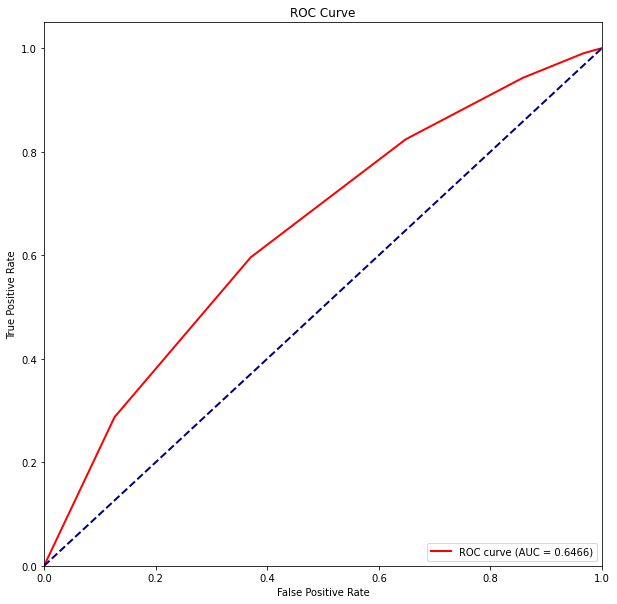

In [12]:
# Plot the AUC curve

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='red',
lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

<a id='section_3'></a>
# 3. Remarks for $k-$NN

## 3.1. Model Complexity

A few remarks are in order for the $k-$NN model. First of all, the parameter $k$ essentially captures the complexity of the model. Specifically, the smaller the $k$, the more complex the model. We will discuss the implication of model complexity on prediction performance in the document on bias-variance tradeoff. The complexities of $k-$NN models with different $k$'s are illustrated in the following figure, which clearly shows the model is more complex (i.e., the border line for different labels is more zigzagged) if $k$ is smaller. Please also note that here model complexity does NOT refer to the time complexity of the algorithm. Instead, it means the complexity of the decision rule to classify the new data points with labels.

<img src="knn-complexity.png" width=750>

## 3.2. Accuracy and Speed

Although the birth of $k-$NN dates back to 1960s, it is a very powerful model in the sense that the prediction accuracy can be very high in general when the size of the training set $n$ is large. In fact, one can theoretically show that, under some reasonable assumptions about the true data generating process, the 0-1 Loss will converge to 0 as the sample size $n$ goes to infinity. A drawback of the $k-$NN model is that it is very slow with a large training data set sample size $n$. This is because the model needs to compute the distance between each data point in the training set and that in the validation set. Later in this course, we will study how to use tree-based models and heuristics to leverage the advantage of $k-$NN but with a much shorter computational time.  

Linear regression and logistic regression belong to the family of parametric models ([Wiki Page](https://en.wikipedia.org/wiki/Parametric_model)), whereas $k-$NN is referred to as a non-parametric model ([Wiki Page](https://en.wikipedia.org/wiki/Nonparametric_statistics)). In statistics and machine learning, we call a model that can be captured by a finite-dimensional parameter vector a parametric model, which is the case of linear regression and logistic regression (parameterized by $(\beta_0,\beta_1,...,\beta_p)$). The $k-$NN model, however, cannot be represented by a finite-dimensional parameter vector.  

## 3.3. $k-$NN Regression

Finally, we remark that $k-$NN can also be used to address regression problems. Recall that, for a regression problem, the outcome $Y$ is a continuous variable. The intuition for $k-$NN regression is very similar to that for $k-$NN classification: The distance (in the feature space) reliably reflects similarities in the outcomes. The main difference between $k-$NN regression and $k-$NN classification is that, instead of taking a majority vote, $k-$NN regression predicts the outcome equal to the average outcome of its $k$ nearest neighbors in the training set. 

Given the training set $\mathcal D:=\{Y_i\in\mathbb R,X_{ij}:1\le i\le n,1\le j \le p\}$, the $k-$NN model predicts the outcome $Y$ of a new datapoint with feature $X$ as follows:

-------------

<font color=red>
    
1. Compute the distance between $X$ and each data point in $\mathcal D$: $d_i:=d(X,X_i)$ for all $i=1,2,...,n$.
2. Find $k$ data points in $\mathcal D$ who are closest to $X$, i.e., who have the smallest $d_i$, which we denote as $\hat{\mathcal D}_k(X)$.
3. Predict the outcome using the average outcome of the $k$ data points in $\hat{\mathcal D}_k(X)$, i.e., 
$$\hat Y=\hat f(X)=\frac{1}{k}\sum_{i\in \hat{\mathcal D}_k(X)}Y_i$$

</font>
    
---------------

In Python, we could use the module ```KNeighborsRegressor``` in the ```sklearn``` package to fit a $k-$NN regression model. See the [this Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) for more details. You may work on your own to predict the hotel room prices using the $k$NN regression model.

#  4. Concluding Remarks

The inability to handle the **non-linear relationship** between label and features motivates us build the non-parametric $k$NN model. The $k$NN model is very accurate if the distance in the feature space reliably reflects label similarity. The downside of the $k$NN model is that it suffers from the curse of dimensionality. Furthermore, the $k$NN model is computationally not quite scalable.